In [62]:
import os

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
from matplotlib.patches import Rectangle
from joblib import Parallel, delayed

In [4]:
DATASET_DIR = r'/Users/zhuyue/Code/Datasets/uw-madison-gi-tract-image-segmentation'

In [5]:
df = pd.read_csv(f'{DATASET_DIR}/train.csv')
df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [25]:
def get_metadata(row):
    case, day, _, slice_id = row['id'].split('_')
    case, day = case.replace('case', ''), day.replace('day', '')
    row['case'], row['day'], row['slice'] = int(case), int(day), int(slice_id)

    return row

In [26]:
df = df.progress_apply(get_metadata, axis=1)

  0%|          | 0/115488 [00:00<?, ?it/s]

In [27]:
df.head()

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1
2,case123_day20_slice_0001,stomach,NaN,123,20,1
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2


In [15]:
paths = glob(f'{DATASET_DIR}/train/*/*/*/*')
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df.head()

,image_path
0,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
3,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
4,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...


In [17]:
'/Users/zhuyue/Code/Datasets/uw-madison-gi-tract-image-segmentation/train/case22/case22_day0/scans/slice_0131_266_266_1.50_1.50.png'.split('/')

['',
 'Users',
 'zhuyue',
 'Code',
 'Datasets',
 'uw-madison-gi-tract-image-segmentation',
 'train',
 'case22',
 'case22_day0',
 'scans',
 'slice_0131_266_266_1.50_1.50.png']

In [19]:
def path2info(row):
    path = row['image_path']
    data = path.split('/')
    slice_id = int(data[-1].split('_')[1])
    case = int(data[-3].split('_')[0].replace('case',''))
    day = int(data[-3].split('_')[1].replace('day',''))
    width = int(data[-1].split('_')[2])
    height = int(data[-1].split('_')[3])

    row['height'] = height
    row['width'] = width
    row['case'] = case
    row['day'] = day
    row['slice'] = slice_id

    return row

In [20]:
path_df = path_df.progress_apply(path2info, axis=1)
path_df.head()

  0%|          | 0/38496 [00:00<?, ?it/s]

,image_path,height,width,case,day,slice
0,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,22,0,131
1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,22,0,32
2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,22,0,84
3,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,22,0,92
4,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,22,0,24


In [28]:
df = df.merge(path_df, on=['case','day','slice'])
df.head()

,id,class,segmentation,case,day,slice,image_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266


In [35]:
def rle_decode(mask_rle, shape):
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [36]:
def id2mask(slice_id):
    idf = df[df['id'] == slice_id]
    wh = idf[['height', 'width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, cls in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        cdf = idf[idf['class'] == cls]
        rle = cdf.segmentation.squeeze()
        if len(cdf) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

In [37]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32')
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    plt.imshow(img, cmap='bone')

    if mask is not None:
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

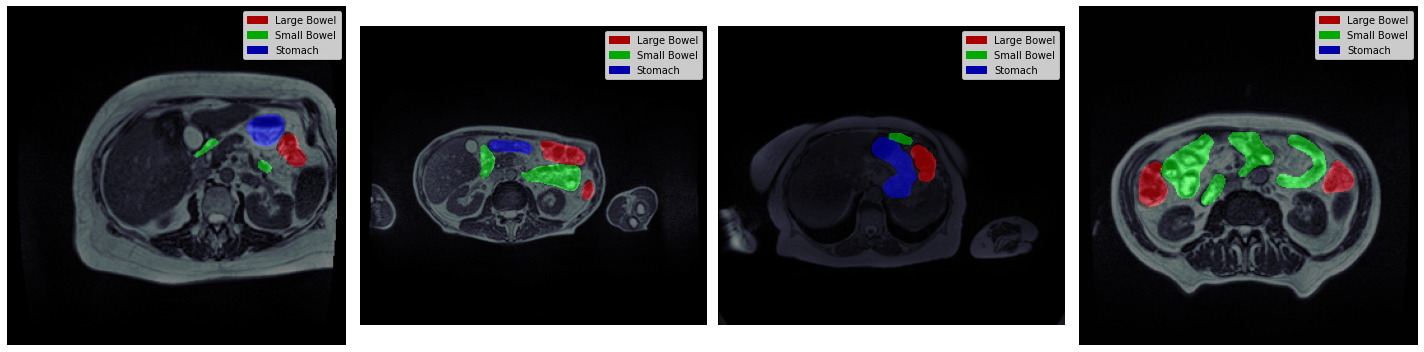

In [38]:
row=1; col=4
plt.figure(figsize=(5*col, 5*row))
for i, slice_id in enumerate(df[~df.segmentation.isna()].sample(frac=1.0)['id'].unique()[:row * col]):
    img = load_img(df[df['id'] == slice_id].image_path.iloc[0])
    mask = id2mask(slice_id) * 255
    plt.subplot(row, col, i+1)
    i += 1
    show_img(img, mask=mask)
    plt.tight_layout()

In [53]:
def save_mask(slice_id):
    idf = df[df['id'] == slice_id]
    mask = id2mask(slice_id)
    image_path = idf.image_path.iloc[0]
    mask_path = image_path.replace('uw-madison-gi-tract-image-segmentation', 'uw-madison-gi-tract-image-segmentation-mask')
    mask_folder = mask_path.rsplit('/', 1)[0]
    os.makedirs(mask_folder, exist_ok=True)
    cv2.imwrite(mask_path, mask * 255, [cv2.IMWRITE_PNG_COMPRESSION, 1])

In [54]:
ids = df['id'].unique()
len(ids)

38496

In [55]:
columns=["id", "case", "day", "slice", "empty", "image"]
class_labels = {
    1:"Large Bowel",
    2:"Small Bowel",
    3:"Stomach",
}

In [56]:
_ = Parallel(n_jobs=1, backend='threading')(delayed(save_mask)(slice_id) for slice_id in tqdm(ids, total=len(ids)))

  0%|          | 0/38496 [00:00<?, ?it/s]

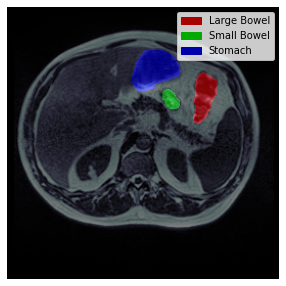

In [57]:
i = 250
img = load_img(df.image_path.iloc[i])
mask_path = df['image_path'].iloc[i].replace('uw-madison-gi-tract-image-segmentation', 'uw-madison-gi-tract-image-segmentation-mask')
mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(5, 5))
show_img(img, mask=mask)

In [58]:
df['mask_path'] = df.image_path.str.replace('uw-madison-gi-tract-image-segmentation', 'uw-madison-gi-tract-image-segmentation-mask')
df.head()

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...


In [60]:
DIR = DATASET_DIR.replace('uw-madison-gi-tract-image-segmentation', 'uw-madison-gi-tract-image-segmentation-mask')
df.to_csv(f'{DIR}/train.csv', index=False)

In [61]:
pd.read_csv(f'{DIR}/train.csv').head()

,id,class,segmentation,case,day,slice,image_path,height,width,mask_path
0,case123_day20_slice_0001,large_bowel,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
1,case123_day20_slice_0001,small_bowel,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
2,case123_day20_slice_0001,stomach,NaN,123,20,1,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
3,case123_day20_slice_0002,large_bowel,NaN,123,20,2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
4,case123_day20_slice_0002,small_bowel,NaN,123,20,2,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...,266,266,/Users/zhuyue/Code/Datasets/uw-madison-gi-trac...
